In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [4]:
import random

def display_images(folders, sample_size):
    for folder in folders:
        images = random.sample(os.listdir(folder), sample_size)
    
        for img in images:
            print(folder)
            display(Image(filename=os.path.join(folder, img)))

In [5]:
display_images(train_folders, 1)

notMNIST_large/A


notMNIST_large/B


notMNIST_large/C


notMNIST_large/D


notMNIST_large/E


notMNIST_large/F


notMNIST_large/G


notMNIST_large/H


notMNIST_large/I


notMNIST_large/J


In [6]:
display_images(test_folders, 1)

notMNIST_small/A


notMNIST_small/B


notMNIST_small/C


notMNIST_small/D


notMNIST_small/E


notMNIST_small/F


notMNIST_small/G


notMNIST_small/H


notMNIST_small/I


notMNIST_small/J


In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

In [8]:
def display_samples(pickle_filename):
    try:
        dataset = pickle.load(open(pickle_filename, 'rb'))
    except Exception as e:
        print('Unable to read data from', pickle_filename, ':', e)
        return
    
    folder = pickle_filename.split('/')[-1].split('.')[0]
    
    plt.suptitle(''.join(folder)[-1])
    
    for i, img in enumerate(random.sample(list(dataset), 8)):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img)

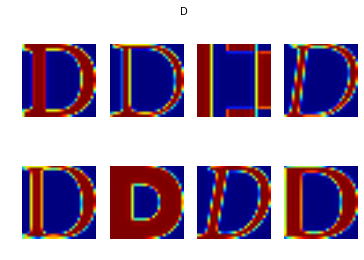

In [9]:
train_pickle_filename = random.sample(train_datasets, 1)
display_samples(train_pickle_filename[0])

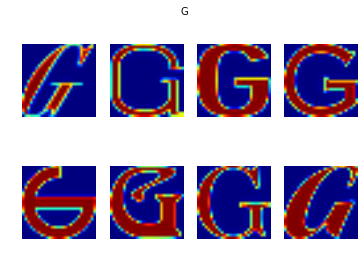

In [10]:
test_pickle_filename = random.sample(test_datasets, 1)
display_samples(test_pickle_filename[0])

In [11]:
def display_number_images(datasets):
    for pickle_filename in datasets:
        try:
            dataset = pickle.load(open(pickle_filename, 'rb'))
        except Exception as e:
            print('Unable to read data from', pickle_filename, ':', e)
            return
        
        print('Number of Images in ', pickle_filename.split('.')[0], ': ', len(dataset))

In [12]:
display_number_images(train_datasets)
display_number_images(test_datasets)

Number of Images in  notMNIST_large/A :  52909
Number of Images in  notMNIST_large/B :  52911
Number of Images in  notMNIST_large/C :  52912
Number of Images in  notMNIST_large/D :  52911
Number of Images in  notMNIST_large/E :  52912
Number of Images in  notMNIST_large/F :  52912
Number of Images in  notMNIST_large/G :  52912
Number of Images in  notMNIST_large/H :  52912
Number of Images in  notMNIST_large/I :  52912
Number of Images in  notMNIST_large/J :  52911
Number of Images in  notMNIST_small/A :  1872
Number of Images in  notMNIST_small/B :  1873
Number of Images in  notMNIST_small/C :  1873
Number of Images in  notMNIST_small/D :  1873
Number of Images in  notMNIST_small/E :  1873
Number of Images in  notMNIST_small/F :  1872
Number of Images in  notMNIST_small/G :  1872
Number of Images in  notMNIST_small/H :  1872
Number of Images in  notMNIST_small/I :  1872
Number of Images in  notMNIST_small/J :  1872


In [13]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [14]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [15]:
label_2_letter = 'ABCDEFGHIJ'

def display_sample_dataset(dataset, labels):
    for i, label in enumerate(random.sample(range(len(labels)), 8)):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(label_2_letter[labels[label]])
        plt.imshow(dataset[label])

Train Shuffled Sample


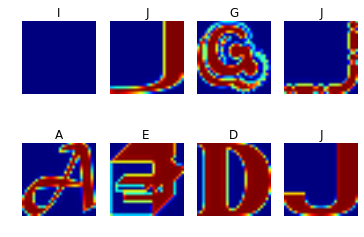

In [16]:
print('Train Shuffled Sample')
display_sample_dataset(train_dataset, train_labels)

Test Shuffled Sample


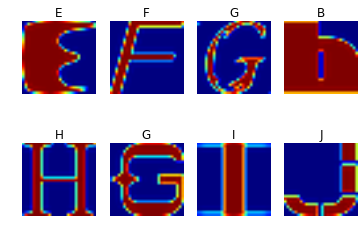

In [17]:
print('Test Shuffled Sample')
display_sample_dataset(test_dataset, test_labels)

Valid Shuffled Sample


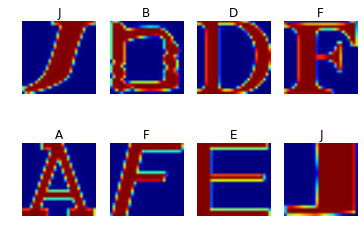

In [19]:
print('Valid Shuffled Sample')
display_sample_dataset(valid_dataset, valid_labels)

In [20]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [21]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


In [22]:
import hashlib

def compute_hashset(dataset):
    hashes = {}
    hash_2_img = {}
    
    for img in dataset:
        h = hashlib.sha256(img).hexdigest()
        hashes[h] = hashes.get(h, 0) + 1
        hash_2_img[h] = img
        
    return hashes, hash_2_img

def compute_overlaps(source_dataset_hashes, target_dataset_hashes):
    total_overlaps = 0
    overlaps = set()
    
    for target_key, i in target_dataset_hashes.items():
        if target_key in source_dataset_hashes:
            total_overlaps += i
            overlaps.add(target_key)
    
    return total_overlaps, overlaps

def display_overlaps(overlaps, source_dataset, target_dataset, sample_size):
    samples = random.sample(overlaps, sample_size)
    
    for i, s in enumerate(samples):
        plt.subplot(sample_size, 2, 2*i+1)
        plt.axis('off')
        plt.title('source')
        plt.imshow(source_dataset[s])
        
        plt.subplot(sample_size, 2, 2*(i+1))
        plt.axis('off')
        plt.title('target')
        plt.imshow(target_dataset[s])

In [23]:
try:
    data = pickle.load(open(pickle_file, 'rb'))
except Exception as e:
    print('Unable to read data from', pickle_file, ':', e)
    
train_hashes, train_hash_2_img = compute_hashset(data['train_dataset'])
test_hashes, test_hash_2_img = compute_hashset(data['test_dataset'])
valid_hashes, valid_hash_2_img = compute_hashset(data['valid_dataset'])

Number of overlaps:  1324


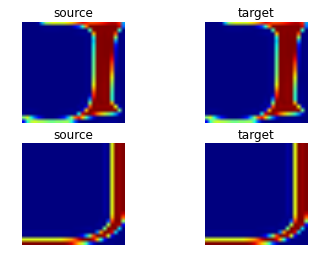

In [24]:
train_test_n_overlaps, train_test_overlaps = compute_overlaps(train_hashes, test_hashes)
print("Number of overlaps: ", train_test_n_overlaps)
display_overlaps(train_test_overlaps, train_hash_2_img, test_hash_2_img, 2)

Number of overlaps:  1067


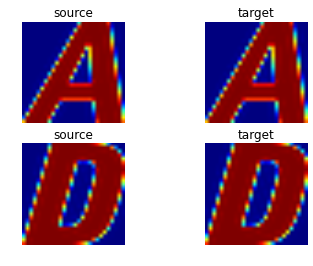

In [25]:
train_valid_n_overlaps, train_valid_overlaps = compute_overlaps(train_hashes, valid_hashes)
print("Number of overlaps: ", train_valid_n_overlaps)
display_overlaps(train_valid_overlaps, train_hash_2_img, valid_hash_2_img, 2)

Number of overlaps:  153


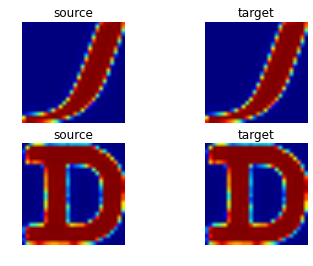

In [26]:
test_valid_n_overlaps, test_valid_overlaps = compute_overlaps(test_hashes, valid_hashes)
print("Number of overlaps: ", test_valid_n_overlaps)
display_overlaps(test_valid_overlaps, test_hash_2_img, valid_hash_2_img, 2)

In [27]:
def sanitize(source_dataset, target_dataset, target_labels):
    overlaps = set()
    source_hashes = set([hashlib.sha256(img).hexdigest() for img in source_dataset])
    target_hashes = [hashlib.sha256(img).hexdigest() for img in target_dataset]
    
    for i, target_hash in enumerate(target_hashes):
        if target_hash in source_hashes:
            overlaps.add(i)
            
    overlaps = list(overlaps)
            
    return np.delete(target_dataset, overlaps, 0), np.delete(target_labels, overlaps, 0)
    

In [28]:
sanitized_test_dataset, sanitized_test_labels = sanitize(data['train_dataset'],
                                                         data['test_dataset'], data['test_labels'])
sanitized_valid_dataset, sanitized_valid_labels = sanitize(data['train_dataset'],
                                                          data['valid_dataset'], data['valid_labels'])

In [29]:
sanitized_pickle_file = 'sanitized-notMNIST.pickle'

try:
  f = open(sanitized_pickle_file, 'wb')
  save = {
    'train_dataset': data['train_dataset'],
    'train_labels': data['train_labels'],
    'valid_dataset': sanitized_valid_dataset,
    'valid_labels': sanitized_valid_labels,
    'test_dataset': sanitized_test_dataset,
    'test_labels': sanitized_test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(sanitized_pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 683292701


In [30]:
x_test = data['test_dataset'].reshape(data['test_dataset'].shape[0], 28*28)
y_test = data['test_labels']

def train_predict(sample_size, solver='liblinear'):
    model = LogisticRegression(solver=solver)
    x_train = data['train_dataset'][:sample_size].reshape(sample_size, 28*28)
    y_train = data['train_labels'][:sample_size]
    
    %time model.fit(x_train, y_train)
    
    print(model.score(x_test, y_test))
    
    pred_labels = model.predict(x_test)

    print('Predictions: ')
    display_sample_dataset(data['test_dataset'], pred_labels)

CPU times: user 47.7 ms, sys: 2.27 ms, total: 50 ms
Wall time: 52.6 ms
0.509
Predictions: 


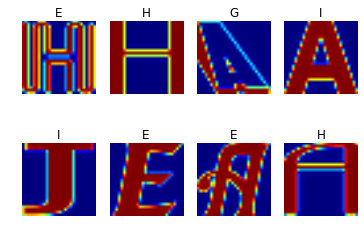

In [31]:
train_predict(50)

CPU times: user 120 ms, sys: 2.54 ms, total: 122 ms
Wall time: 123 ms
0.6966
Predictions: 


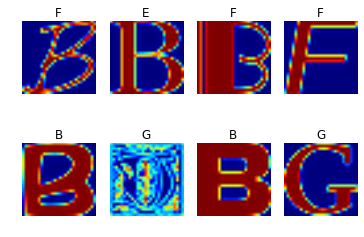

In [32]:
train_predict(100)

CPU times: user 2.98 s, sys: 39.2 ms, total: 3.02 s
Wall time: 3.06 s
0.8333
Predictions: 


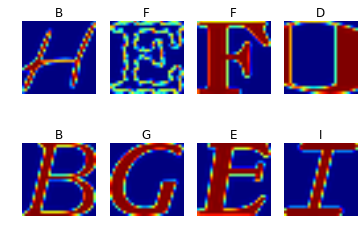

In [33]:
train_predict(1000)

CPU times: user 23 s, sys: 154 ms, total: 23.1 s
Wall time: 23.4 s
0.8511
Predictions: 


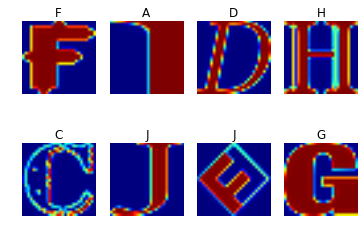

In [34]:
train_predict(5000)

CPU times: user 16min 34s, sys: 11.2 s, total: 16min 45s
Wall time: 18min 14s
0.8932
Predictions: 


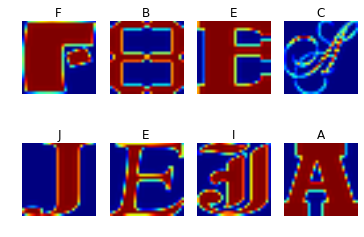

In [35]:
train_predict(len(data['train_dataset']), 'sag')